In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential, Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout,SeparableConv2D,DepthwiseConv2D,Input, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import regularizers
from keras.layers.merge import concatenate
from keras.layers import Lambda
from keras import optimizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
img_height, img_width, channel = train_features.shape[1],train_features.shape[2],train_features.shape[3]
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


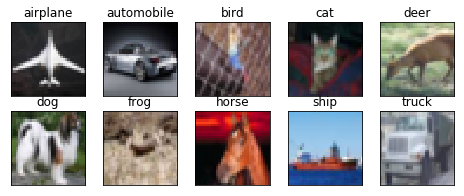

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2) 

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [8]:
input1 = Input(shape=(img_height, img_width, channel)) ## define input
print(input1.shape)
type(input1)

W0622 07:21:09.194745 140065574848384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0622 07:21:09.234921 140065574848384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



(?, 32, 32, 3)


tensorflow.python.framework.ops.Tensor

In [50]:
seperable_5_1 = (SeparableConv2D(48,(5,5),  padding='same', data_format=None, dilation_rate=(1, 1), depth_multiplier=1, activation=None, use_bias=False, depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform'))(input1) 
seperable_5_1 = (BatchNormalization())(seperable_5_1)
seperable_5_1 = (Activation('relu'))(seperable_5_1)

skip_con_seperable_5_1 = seperable_5_1


## first 5x5 convolution layer
conv_5_1 = (Convolution2D(48, 5, 5, border_mode='same',  kernel_regularizer=regularizers.l2(0.001)))(seperable_5_1) 
conv_5_1 = (BatchNormalization())(conv_5_1) 
conv_5_1 = (Activation('relu'))(conv_5_1) 

skip_con_conv_5_1 = conv_5_1


## second 5x5 convolution layer
conv_5_2 = (Convolution2D(48, 5, 5, border_mode='same',  kernel_regularizer=regularizers.l2(0.001)))(conv_5_1) 
conv_5_2 = (BatchNormalization())(conv_5_2) 
conv_5_2 = (Activation('relu'))(conv_5_2) 

skip_con_conv_5_2 = conv_5_2



## second 5x5 seperable layer

seperable_5_2 = concatenate([ skip_con_seperable_5_1,conv_5_2])
seperable_5_2 = (SeparableConv2D(48,(5,5),  padding='same', data_format=None, dilation_rate=(1,1), depth_multiplier=1, activation=None, use_bias=False, depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform'))(seperable_5_2) 
seperable_5_2 = (BatchNormalization())(seperable_5_2)
seperable_5_2 = (Activation('relu'))(seperable_5_2)

skip_con_seperable_5_2 = seperable_5_2

##print(seperable_5_1.shape)
##print(seperable_5_2.shape)
##print(skip_con_seperable_5_2.shape)
##print(skip_con_seperable_5_1.shape)

seperable_5_2 = concatenate([ skip_con_seperable_5_1,skip_con_seperable_5_2])

## first Maxpooling layer

skip_con_maxpool_1 = MaxPooling2D(pool_size=(2,2))(seperable_5_2)

## first 3x3 seperable

seperable_3_1 = SeparableConv2D(48,3,strides=1,padding='same',data_format=None,dilation_rate=(1,1), depth_multiplier=1, activation=None, use_bias=False, depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform')(skip_con_maxpool_1) 
seperable_3_1 = BatchNormalization(axis = 3)(seperable_3_1)
seperable_3_1 = Activation('relu')(seperable_3_1)

skip_seperable_3_1 = seperable_3_1

## third conv5x5

conv_5_3 = concatenate([skip_con_seperable_5_1, skip_con_seperable_5_2])
conv_5_3 = Lambda(space_to_depth_x2)(conv_5_3)
concat_conv_5_3 = conv_5_3
conv_5_3 = concatenate([conv_5_3, seperable_3_1])


conv_5_3 = (Convolution2D(48, 5, 5, border_mode='same',  kernel_regularizer=regularizers.l2(0.001)))(conv_5_3) 
conv_5_3 = (BatchNormalization())(conv_5_3) 
conv_5_3 = (Activation('relu'))(conv_5_3)

skip_conv_5_3 = conv_5_3

## second 3x3 seperable

seperable_3_2 = concatenate([conv_5_2,seperable_5_2])
seperable_3_2 = Lambda(space_to_depth_x2)(seperable_3_2)
seperable_3_2 = concatenate([seperable_3_2, conv_5_3])


seperable_3_2 = SeparableConv2D(48,3,strides=1,padding='same',data_format=None,dilation_rate=(1,1), depth_multiplier=1, activation=None, use_bias=False, depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform')(seperable_3_2) 
seperable_3_2 = BatchNormalization(axis = 3)(seperable_3_2)
seperable_3_2 = Activation('relu')(seperable_3_2)

skip_seperable_3_2 = seperable_3_2

## third 5x5 seperable layer

seperable_5_3 = concatenate([skip_con_seperable_5_1, skip_con_conv_5_2, skip_con_seperable_5_2])
seperable_5_3 = Lambda(space_to_depth_x2)(seperable_5_3)
concat_seperable_5_3 = seperable_5_3
seperable_5_3 = concatenate([seperable_5_3, skip_seperable_3_1, skip_conv_5_3, seperable_3_2])

seperable_5_3 = SeparableConv2D(48,5,strides=1,padding='same',data_format=None,dilation_rate=(1,1), depth_multiplier=1, activation=None, use_bias=False, depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform')(seperable_5_3) 
seperable_5_3 = BatchNormalization(axis = 3)(seperable_5_3)
seperable_5_3 = Activation('relu')(seperable_5_3)

skip_seperable_5_3 = seperable_5_3

## maxpool2

skip_con_maxpool_2 = concatenate([concat_conv_5_3, skip_seperable_3_1, skip_seperable_3_2, seperable_5_3])
skip_con_maxpool_2 = MaxPooling2D(pool_size=(2,2))(skip_con_maxpool_2)

## fourth conv5x5

conv_5_4 = Lambda(space_to_depth_x2)(skip_conv_5_3)
conv_5_4 = concatenate([conv_5_4, skip_con_maxpool_2])

conv_5_4 = (Convolution2D(48, 5, 5, border_mode='same',  kernel_regularizer=regularizers.l2(0.001)))(conv_5_4) 
conv_5_4 = (BatchNormalization())(conv_5_4) 
conv_5_4 = (Activation('relu'))(conv_5_4)

skip_conv_5_4 = conv_5_4

## seperable_5_4
seperable_5_4 = concatenate([skip_con_conv_5_2, seperable_5_2])
seperable_5_4 = Lambda(space_to_depth_x2)(seperable_5_4)
seperable_5_4 = Lambda(space_to_depth_x2)(seperable_5_4)
concat_seperable_5_4 = Lambda(space_to_depth_x2)(skip_seperable_3_2)
seperable_5_4 = concatenate([seperable_5_4, concat_seperable_5_4, conv_5_4])

seperable_5_4 = SeparableConv2D(48,5,strides=1,padding='same',data_format=None,dilation_rate=(1,1), depth_multiplier=1, activation=None, use_bias=False, depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform')(seperable_5_4) 
seperable_5_4 = BatchNormalization(axis = 3)(seperable_5_4)
seperable_5_4 = Activation('relu')(seperable_5_4)

skip_seperable_5_4 = seperable_5_4

## first 3x3 conv

conv_3_1 = concatenate([skip_con_conv_5_1, skip_con_conv_5_2])
conv_3_1 = Lambda(space_to_depth_x2)(conv_3_1)
conv_3_1 = Lambda(space_to_depth_x2)(conv_3_1)
concat_conv_3_1 = Lambda(space_to_depth_x2)(skip_seperable_3_1)
conv_3_1 = concatenate([conv_3_1, concat_conv_3_1, skip_conv_5_4, seperable_5_4])

conv_3_1 = (Convolution2D(48, 3, 3, border_mode='same',  kernel_regularizer=regularizers.l2(0.001)))(conv_3_1) 
conv_3_1 = (BatchNormalization())(conv_3_1) 
conv_3_1 = (Activation('relu'))(conv_3_1)

skip_conv_3_1 = conv_3_1

## fifth 5x5 seperable

seperable_5_5 = concatenate([skip_con_seperable_5_1, skip_con_conv_5_2, skip_con_seperable_5_2])
seperable_5_5 = Lambda(space_to_depth_x2)(seperable_5_5)
seperable_5_5 = Lambda(space_to_depth_x2)(seperable_5_5)
concat_seperable_5_5 = concatenate([skip_seperable_3_1, skip_seperable_3_2])
concat_seperable_5_5 = Lambda(space_to_depth_x2)(concat_seperable_5_5)
conv_3_1 = concatenate([seperable_5_5, concat_seperable_5_5, skip_seperable_5_4, conv_3_1])

seperable_5_5 = SeparableConv2D(48,5,strides=1,padding='same',data_format=None,dilation_rate=(1,1), depth_multiplier=1, activation=None, use_bias=False, depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform')(conv_3_1) 
seperable_5_5 = BatchNormalization(axis = 3)(seperable_5_5)
seperable_5_5 = Activation('relu')(seperable_5_5)

## softmax


concat_softmax = Lambda(space_to_depth_x2)(skip_con_seperable_5_2)
concat_softmax = Lambda(space_to_depth_x2)(concat_softmax)
concat_concat_softmax = Lambda(space_to_depth_x2)(skip_seperable_3_2)
softmax = concatenate([concat_softmax, concat_concat_softmax, skip_seperable_5_4, conv_3_1])

softmax = (Convolution2D(10,1, border_mode='same',  kernel_regularizer=regularizers.l2(0.001)))(softmax)
softmax = GlobalAveragePooling2D(data_format= 'channels_last')(softmax)
#x = Flatten()(x)
output = Activation('softmax')(softmax)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), kernel_regularizer=<keras.reg..., padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), kernel_regularizer=<keras.reg..., padding="sam

In [51]:
model = Model(inputs=[input1], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_150 (Separable (None, 32, 32, 48)   219         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_267 (BatchN (None, 32, 32, 48)   192         separable_conv2d_150[0][0]       
__________________________________________________________________________________________________
activation_298 (Activation)     (None, 32, 32, 48)   0           batch_normalization_267[0][0]    
__________________________________________________________________________________________________
conv2d_120

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(zoom_range=0.0, 
                             featurewise_center=True,
                             featurewise_std_normalization=True,
                             horizontal_flip=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=97, epochs=100)`
  """
W0622 15:13:22.022018 140065574848384 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instr

Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


97/97 [==============================] - 92s 950ms/step - loss: 1.7433 - acc: 0.4251 - val_loss: 2.6435 - val_acc: 0.2931
Epoch 2/100
97/97 [==============================] - 69s 711ms/step - loss: 1.2774 - acc: 0.5947 - val_loss: 2.0570 - val_acc: 0.3990
Epoch 3/100
97/97 [==============================] - 65s 669ms/step - loss: 1.0892 - acc: 0.6664 - val_loss: 1.5988 - val_acc: 0.5188
Epoch 4/100
97/97 [==============================] - 65s 671ms/step - loss: 0.9760 - acc: 0.7121 - val_loss: 1.9259 - val_acc: 0.5354
Epoch 5/100
97/97 [==============================] - 65s 669ms/step - loss: 0.8857 - acc: 0.7435 - val_loss: 1.8218 - val_acc: 0.5336
Epoch 6/100
97/97 [==============================] - 65s 670ms/step - loss: 0.8114 - acc: 0.7704 - val_loss: 1.4462 - val_acc: 0.5956
Epoch 7/100
97/97 [==============================] - 65s 670ms/step - loss: 0.7604 - acc: 0.7906 - val_loss: 2.4242 - val_acc: 0.5025
Epoch 8/100
97/97 [==============================] - 65s 670ms/step - loss

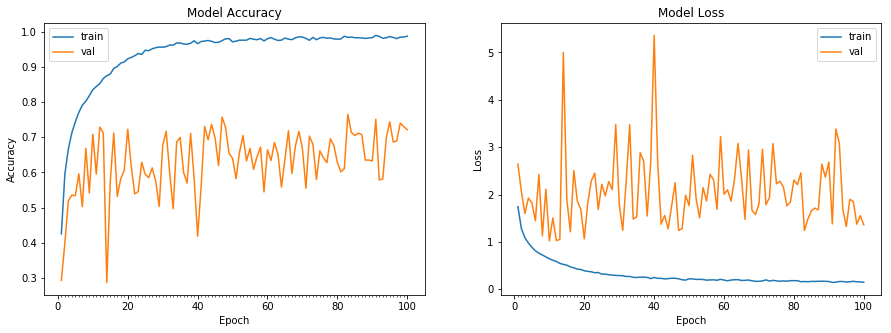

Accuracy on test data is: 72.13


In [54]:
# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 512),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))